# Import modules

In [27]:
import secrets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform
sns.set(style="whitegrid")

In [28]:
# Add at the beginning of your notebook to make imports work
import sys
import os

# Get the absolute path to the project root directory (one level up from notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to Python's import path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")

In [29]:
project_root

'/Users/amber/Desktop/Research/avail-fusion'

In [30]:
from dataclasses import dataclass, field
from typing import TypedDict, List, Callable, NamedTuple


from model.utils import default, update_from_signal
import visualizations

In [31]:
from config.params import FusionParams
from config.initialize_simulation import initialize_state
from model.agents_class import AgentStake
from model.rewards import calculate_reward_allocation
from model.stochastic_processes import (
    create_stochastic_avail_price_process, plot_price,
    create_linear_price_growth, create_compound_price_growth, create_trend_with_noise_price
)

from real_data_fetcher import fetch

from config.psub import psub

from config.config import TIMESTEPS, DELTA_TIME


# Price Traj Generation

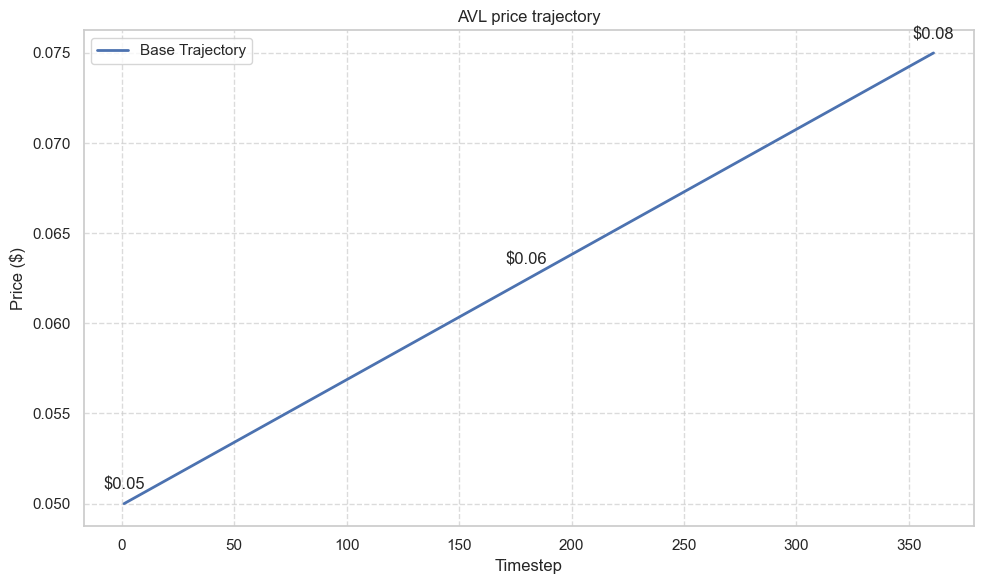

<Figure size 640x480 with 0 Axes>

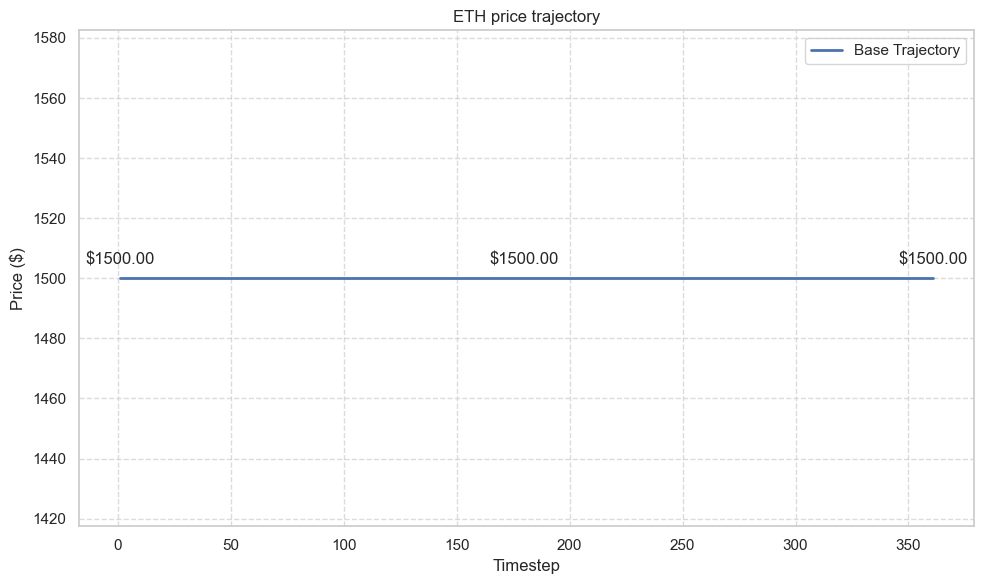

<Figure size 640x480 with 0 Axes>

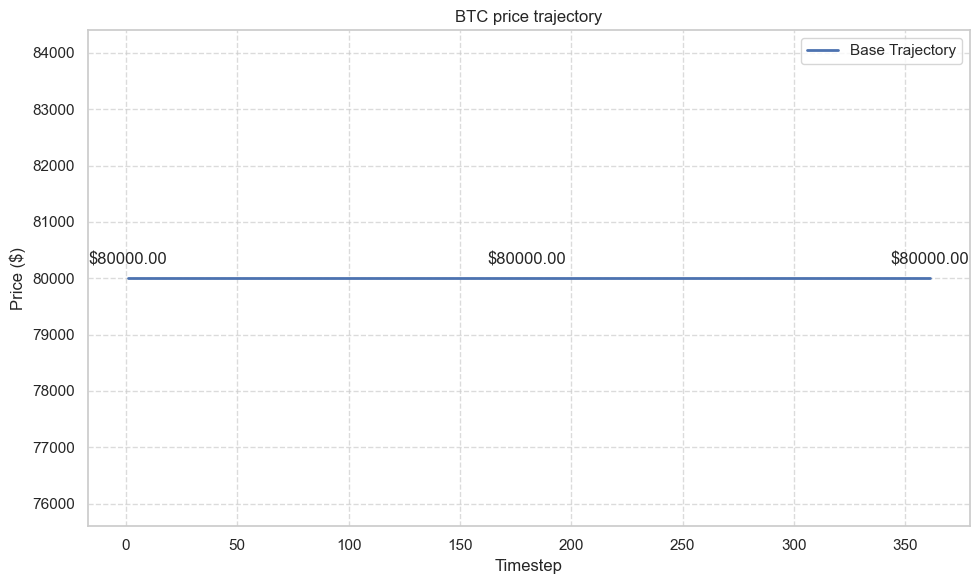

<Figure size 640x480 with 0 Axes>

In [32]:
# types
Run = int
Timestep = int

annual_growth_rate = 0.5  # 50% compound annual growth rate

avl_price_samples = create_linear_price_growth(
    starting_price=0.05, annual_increase_pct = 0.5
)

# from config.config import (
#     TIMESTEPS,
#     DELTA_TIME,
# )
# avl_price_samples = [0.1] * TIMESTEPS

plot_price(
    avl_price_samples,
    title="AVL price trajectory"
)

eth_price_samples = create_linear_price_growth(
    starting_price=1500, annual_increase_pct = 0
)

plot_price(
    eth_price_samples,
    title="ETH price trajectory"
)

btc_price_samples = create_linear_price_growth(
    starting_price=80000, annual_increase_pct = 0
)

plot_price(
    btc_price_samples,
    title="BTC price trajectory"
)

lens_price_samples = create_linear_price_growth(
    starting_price=1, annual_increase_pct = 0
)


In [50]:
def prepare_price_process(
    price_process_type: str = 'linear',
    volatility: float = 0.5,
    trend_type: str = 'linear',
    timesteps: int = TIMESTEPS,
    dt: float = DELTA_TIME
):

    annual_growth_rate = 0.5  # 50% compound annual growth rate

    avl_price_samples = create_linear_price_growth(
        starting_price=0.05, annual_increase_pct = volatility
    )

    eth_price_samples = create_linear_price_growth(
        starting_price=1500, annual_increase_pct = 0
    )

    btc_price_samples = create_linear_price_growth(
        starting_price=80000, annual_increase_pct = 0
    )

    lens_price_samples = create_linear_price_growth(
        starting_price=1, annual_increase_pct = 0
    )

    return avl_price_samples, eth_price_samples, btc_price_samples, lens_price_samples

def prepare_setup(
    AVL_initial_price,
    ETH_initial_price,
):
    def fixed_params(total_supply = 10_000_000_000, avl_price = AVL_initial_price):
        total_fdv = total_supply * avl_price
        return total_fdv

    init_total_fdv = fixed_params(avl_price = AVL_initial_price)
    
    constants =  {
        "total_supply": 10_000_000_000,
        "init_total_fdv": init_total_fdv,
        "native_staking_ratio": 0.5,
    }

    agents = AgentStake.create_maxi_agents(
        target_composition={'AVL': 0, 'ETH': 1, 'BTC': 0},  
        total_tvl=1  # $1M total TVL
    )

    rewards_result = calculate_reward_allocation(
        constants=constants,
        avl_price=0.1,
        total_tvl=250e6,
        avl_stake_pct=0.15,
        target_avl_yield=0.15,
        target_eth_yield=0.035
    )

    return init_total_fdv, constants, agents, rewards_result

def prepare_simulation_parameters(
        constants,
        agents,
        rewards_result,
        avl_price_samples,
        eth_price_samples,
        btc_price_samples,
        lens_price_samples,
):
    """
    Prepare the simulation parameters.
    
    Returns:
        dict: Model parameters dictionary
    """
    # Get the default parameters
    parameters = FusionParams(
        constants=[constants],  # Wrap in list for multiple runs
        avl_price_samples=[avl_price_samples],  # List of price trajectories
        eth_price_samples=[eth_price_samples],
        btc_price_samples=[btc_price_samples],
        lens_price_samples=[lens_price_samples],
        rewards_result=[rewards_result],  # List of reward results
        agents=[agents],  # List of agent configurations
        btc_activation_day=[180]
    ).__dict__
    
    return parameters

def run_simulation(
     label,
     initial_conditions,
     params,
):
    """
    Run a simulation with the given parameters and label.
    
    Args:
        model_params (dict): Model parameters
        label (str): Label for the simulation (e.g., "restaking" or "non_restaking")
        
    Returns:
        tuple: (Model object, DataFrame with results)
    """
    print(f"Running {label} simulation...")
    
    # Initialize and run the model
    model = Model(
        initial_state=initial_conditions,
        state_update_blocks=psub,
        params=params
    )

    simulation=Simulation(model=model, timesteps=TIMESTEPS, runs=1)
    experiment = Experiment([simulation])
    experiment.engine = Engine(deepcopy=True, backend=Backend.SINGLE_PROCESS)
    results = experiment.run()
    df = pd.DataFrame(results)
    
    return model, df

def extract_accumulated_rewards(df):
    """Extract accumulated AVL rewards for each agent over time"""
    timesteps = df['timestep'].tolist()
    
    # Initialize dictionaries to store data for each agent
    agent_rewards = {
        'avl_maxi': [],
        'eth_maxi': [],
        'btc_maxi': []
    }
    
    # Extract data for each timestep
    for _, row in df.iterrows():
        agents = row['agents']
        for agent_name in agent_rewards.keys():
            if agent_name in agents:
                agent_rewards[agent_name].append(agents[agent_name].accu_rewards_avl)
            else:
                agent_rewards[agent_name].append(0)
    
    return timesteps, agent_rewards

def extract_tvl_data(df):
    """Extract TVL for each agent over time"""
    timesteps = df['timestep'].tolist()
    total_tvl = df['total_security'].tolist()
    
    # Initialize dictionaries to store data for each agent
    agent_tvl = {
        'avl_maxi': [],
        'eth_maxi': [],
        'btc_maxi': []
    }
    
    # Extract data for each timestep
    for _, row in df.iterrows():
        agents = row['agents']
        timestep_total = 0
        
        for agent_name in agent_tvl.keys():
            if agent_name in agents:
                agent_tvl_value = agents[agent_name].total_tvl
                agent_tvl[agent_name].append(agent_tvl_value)
                timestep_total += agent_tvl_value
            else:
                agent_tvl[agent_name].append(0)
    
    return timesteps, agent_tvl, total_tvl

def extract_yield_data(df):
    """Extract yield percentages for each agent over time"""
    timesteps = df['timestep'].tolist()
    agent_yields = {}
    
    # Extract data for each timestep
    for _, row in df.iterrows():
        yield_pcts = row['yield_pcts']
        
        for agent_name, yield_pct in yield_pcts.items():
            if agent_name not in agent_yields:
                agent_yields[agent_name] = []
            agent_yields[agent_name].append(yield_pct)
    
    return timesteps, agent_yields

def calculate_effective_apy(df):
    """
    Calculate effective APY based on new rewards earned between consecutive timesteps.
    APY = (new_rewards / effective_tvl) * 365 * 100
    Only takes the last substep data for each timestep.
    """
    # Get unique timesteps
    unique_timesteps = sorted(df['timestep'].unique())
    
    # Initialize dictionaries to store data for each agent
    agent_effective_apy = {
        'avl_maxi': [],
        'eth_maxi': [],
        'btc_maxi': []
    }
    
    # Track previous rewards for each agent
    prev_rewards = {
        'avl_maxi': 0,
        'eth_maxi': 0,
        'btc_maxi': 0
    }
    
    # Extract data for each timestep
    for _, row in df.iterrows():
        agents = row['agents']
        
        for agent_name in agent_effective_apy.keys():
            if agent_name in agents:
                agent = agents[agent_name]
                accu_rewards = agent.accu_rewards_avl
                avl_price = agent.assets['AVL'].price
                accu_rewards_usd = accu_rewards * avl_price
                tvl = agent.total_tvl
                
                # Calculate new rewards since last timestep
                new_rewards_usd = accu_rewards_usd - prev_rewards[agent_name]
                
                # Calculate effective TVL (excluding accumulated rewards)
                effective_tvl = max(tvl - accu_rewards_usd, 1)  # Avoid division by zero
                
                # Calculate annualized APY based on new rewards
                effective_apy = (new_rewards_usd / effective_tvl) * 365 * 100 if effective_tvl > 0 else None
                
                # Only append non-zero APY values
                if effective_apy is not None and effective_apy > 0:
                    agent_effective_apy[agent_name].append(effective_apy)
                prev_rewards[agent_name] = accu_rewards_usd
    
    return timesteps[:len(agent_effective_apy['avl_maxi'])], agent_effective_apy

def plot_accumulated_rewards(timesteps, agent_rewards):
    """Plot accumulated AVL rewards for each agent"""
    plt.figure(figsize=(12, 6))
    
    for agent_name, rewards in agent_rewards.items():
        plt.plot(timesteps, rewards, label=f"{agent_name}")
    
    plt.title("Accumulated AVL Rewards Over Time (Restaking)")
    plt.xlabel("Timestep")
    plt.ylabel("Accumulated AVL Rewards")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/accumulated_rewards.png')
    plt.close()

def plot_tvl_comparison(timesteps, restaking_tvl, non_restaking_tvl):
    """Plot TVL comparison between restaking and non-restaking cases"""
    plt.figure(figsize=(12, 6))
    
    # Plot both lines on the same figure with different styles for clarity
    plt.plot(timesteps, restaking_tvl, label="Restaking", linestyle='-', linewidth=2)
    plt.plot(timesteps, non_restaking_tvl, label="Non-Restaking", linestyle='--', linewidth=2)
    
    plt.title("Total TVL Comparison: Restaking vs. Non-Restaking")
    plt.xlabel("Timestep")
    plt.ylabel("Total TVL (USD)")
    plt.legend(loc='upper left')  # Place legend in upper left to avoid overlapping with lines
    plt.grid(True, alpha=0.3)  # Lighter grid to improve visibility of lines
    plt.tight_layout()
    
    # Save and display the plot
    plt.savefig('plots/tvl_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()  # Show the plot before closing
    plt.close()

def plot_apy_comparison(timesteps, restaking_apy, non_restaking_apy):
    """Plot APY comparison between restaking and non-restaking cases"""
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
    
    agent_colors = {
        'avl_maxi': 'red',
        'eth_maxi': 'blue',
        'btc_maxi': 'green'
    }
    
    # Plot for each agent
    for agent_name in restaking_apy.keys():
        if agent_name in non_restaking_apy:
            # Non-restaking APY (original)
            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=non_restaking_apy[agent_name],
                    name=f"{agent_name} (Non-Restaking)",
                    line=dict(color=agent_colors[agent_name], dash='dash')
                )
            )
            
            # Restaking effective APY
            print("#########################")
            print(len(restaking_apy[agent_name]))
            print(restaking_apy[agent_name])
            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=restaking_apy[agent_name],
                    name=f"{agent_name} (Restaking)",
                    line=dict(color=agent_colors[agent_name], dash='solid')
                )
            )
    
    fig.update_layout(
        title="APY Comparison: Restaking vs. Non-Restaking",
        xaxis_title="Timestep",
        yaxis_title="APY (%)",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        ),
        template="plotly_white"
    )
    
    fig.write_image('plots/apy_comparison.png')
    pio.write_html(fig, 'plots/apy_comparison.html')

def main():
    """Main function to run the comparison."""
    print("Comparing restaking vs. non-restaking effects...")
    
    # Create plots directory if it doesn't exist
    os.makedirs('plots', exist_ok=True)
    
    # Prepare parameters for both scenarios
    avl_price_samples, eth_price_samples, btc_price_samples, lens_price_samples = prepare_price_process(volatility=0.5)
    init_total_fdv, constants, agents, rewards_result = prepare_setup(avl_price_samples[0], eth_price_samples[0])
    
    # Prepare simulation parameters
    sim_params = prepare_simulation_parameters(
        constants,
        agents,
        rewards_result,
        avl_price_samples,
        eth_price_samples,
        btc_price_samples,
        lens_price_samples
    )
    
    # Run restaking simulation (restake_pct = 1.0)
    restaking_initial_conditions = initialize_state(
        init_total_fdv=init_total_fdv, 
        constants=constants, 
        rewards_result=rewards_result, 
        params=sim_params,
        restaking=1.0,
        seed=42
    )
    
    _, restaking_df = run_simulation(
        label="restaking",
        initial_conditions=restaking_initial_conditions,
        params=sim_params
    )
    
    # Run non-restaking simulation (restake_pct = 0.0)
    non_restaking_initial_conditions = initialize_state(
        init_total_fdv=init_total_fdv, 
        constants=constants, 
        rewards_result=rewards_result, 
        params=sim_params,
        restaking=0.0,
        seed=42
    )
    
    _, non_restaking_df = run_simulation(
        label="non-restaking",
        initial_conditions=non_restaking_initial_conditions,
        params=sim_params
    )
    
    # Extract and plot accumulated rewards for restaking case
    timesteps, agent_rewards = extract_accumulated_rewards(restaking_df)
    plot_accumulated_rewards(timesteps, agent_rewards)
    print("Generated accumulated rewards plot")
    
    # Extract and plot TVL comparison
    _, _, restaking_tvl = extract_tvl_data(restaking_df)
    _, _, non_restaking_tvl = extract_tvl_data(non_restaking_df)
    plot_tvl_comparison(timesteps, restaking_tvl, non_restaking_tvl)
    print("Generated TVL comparison plot")
    
    # Extract and plot APY comparison
    _, non_restaking_apy = extract_yield_data(non_restaking_df)
    _, restaking_effective_apy = calculate_effective_apy(restaking_df)
    print(restaking_effective_apy)
    print(len(restaking_effective_apy['avl_maxi']))
    print
    plot_apy_comparison(timesteps, restaking_effective_apy, non_restaking_apy)
    print("Generated APY comparison plot")
    
    print("Comparison complete. Results saved in the 'plots' directory.")

Comparing restaking vs. non-restaking effects...
Running restaking simulation...
###########################
timestep 0
[DEBUG] update_token_prices
{'avl_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=1.0, balance=9000000.0, price=0.05), 'ETH': AssetAllocation(pct=0.0, balance=0, price=1500.0), 'BTC': AssetAllocation(pct=0.0, balance=0, price=80000.0)}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0, restake_pct=1), 'eth_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=0.0, balance=0, price=0.05), 'ETH': AssetAllocation(pct=1.0, balance=300, price=1500.0), 'BTC': AssetAllocation(pct=0.0, balance=0, price=80000.0)}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0, restake_pct=1), 'btc_maxi': AgentStake(assets={'AVL': AssetAllocation(pct=0.0, balance=0, price=0.05), 'ETH': AssetAllocation(pct=0.0, balance=0, price=1500.0), 'BTC': AssetAllocation(pct=0.0, balance=0, price=80000.0)}, curr_annual_rewards_avl=0.0, accu_rewards_avl=0.0, restake_pct=1)}
  AVL Flow: $33,314.00 (D

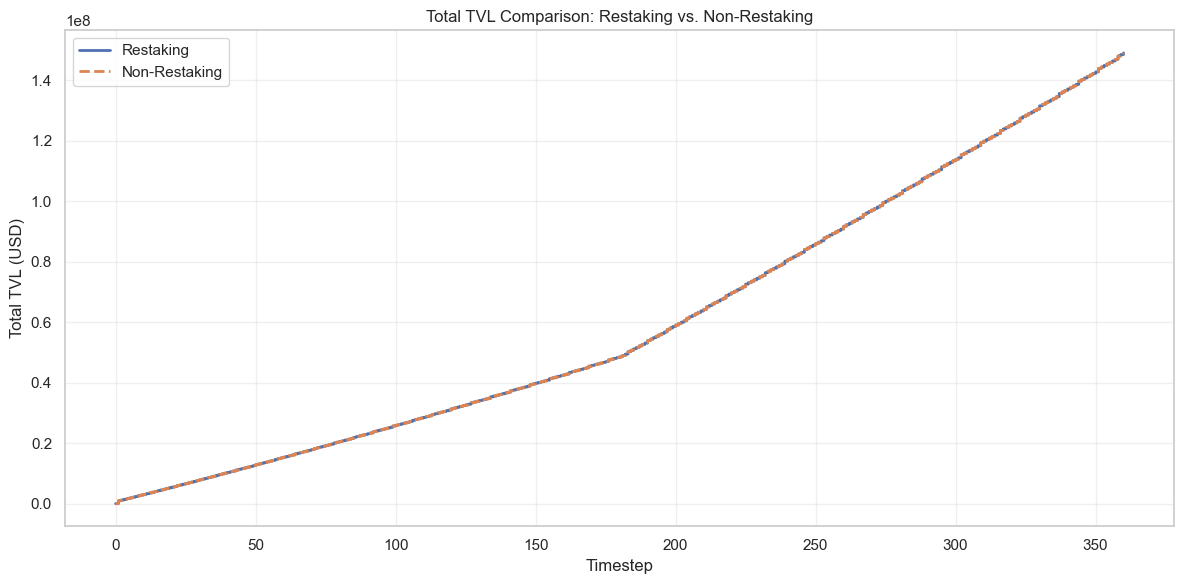

Generated TVL comparison plot
{'avl_maxi': [15.000000000000002, 15.004347371429901, 15.008120071400516, 15.011638270563424, 15.015021801231358, 15.018325656739007, 15.021578620132638, 15.606408215824732, 15.028037854036928, 15.031231957762053, 15.03441024964114, 15.037576438971564, 15.040733210043802, 15.043882553340229, 16.138978409959908, 15.050216088615986, 15.053372566027983, 15.056523754958162, 15.059670548438566, 15.062813674350704, 15.06595373192583, 16.657950929779172, 15.072279647743436, 15.075436700900429, 15.078590531319392, 15.081741578223529, 15.084890219951614, 15.088036784160263, 17.168210955729975, 15.094378453667279, 15.097544812856539, 15.100708638375181, 15.10387021973732, 15.107029814425626, 15.110187652205786, 17.67111291616179, 15.1165526431311, 15.11973131053157, 15.122907754801817, 15.126082193613053, 15.129254824630692, 15.132425827763255, 18.167260325284516, 15.138817259928908, 15.142009510244092, 15.145199709531362, 15.148388032922547, 15.151574641801787, 15.

In [51]:
main()